In [1]:
!pip install vit-pytorch
!pip install timm

In [2]:
from PIL import Image
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import timm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import cv2
import pickle
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import skew, kurtosis,variation, gmean, relfreq
import csv
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, mean_squared_error
from scipy.special import softmax

In [3]:
PATH = /Classification/data/WFT/"
path_to_save = "/Classification/data/temp/"
path_for_models = "/Classification/data/models/"
directional_classifier = ""
fraction = 0.3
HEAD_RATIO = [0, 0.25]
THORAX_RATIO = [0.15, 0.55]
ABDOMEN_RATIO = [0.5, 1]
CLASSIFIER = 'Augmented_ViT' # "Augmented_ViT" for our model, or "ViT"
torch.manual_seed(0)

In [4]:
required_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((972, 1296)),
    transforms.ToTensor(),
])

required_transforms_for_models = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),
    transforms.ToTensor()
])


In [5]:
# processing dataset metadata
def process_dataset_meta_info():
    files = []
    file_paths = os.listdir(PATH)
    file_paths.sort()
    for item in file_paths:
        if item[-4:] == ".jpg":
            files.append(PATH + item)

    return files

files = process_dataset_meta_info()

In [6]:
# reading thrip dataset
class ThripDataset(Dataset):
    def __init__(self, file_paths, transform = None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx] # extract the filepath
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [7]:
thrip_dataset = ThripDataset(files, required_transforms)
thrip_data_loader = DataLoader(thrip_dataset, batch_size  = 1, shuffle = False, num_workers = 1)

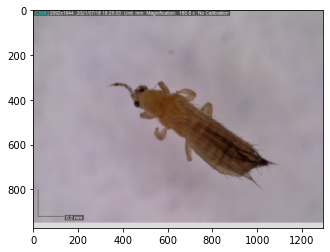

In [8]:
for idx, data in enumerate(thrip_data_loader):
    data = data.detach().cpu().numpy()
    im = np.moveaxis(data[0], 0, -1)
    plt.imshow(im)
    break # remove the break statment if you want to display all the thrip images loaded 

In [9]:
def value_mapping(left, right, is_greater_than):
    if left == right:
        left = 0
        right = 1
    elif is_greater_than:
        if left > right:
            left = 1
            right = 0
        else:
            left = 0
            right = 1
    else:
        if left > right:
            left = 0
            right = 1
        else:
            left = 1
            right = 0
    return left, right     

In [10]:
def number_of_pixels(pixels_arr, fraction = 0.15, offset = 5):
    total_pixel_left = 0
    total_pixel_right = 0
    
    part_length = round(len(pixels_arr)*fraction)
    
    for i in pixels_arr[offset: part_length]:
        total_pixel_left = total_pixel_left + i
        
    for i in pixels_arr[-part_length: -offset]:
        total_pixel_right = total_pixel_right + i
    
    return total_pixel_left, total_pixel_right

In [11]:
def cal_mse(pixels_arr, fraction = 0.33, offset= 5):
    x_axies = list(range(0, len(pixels_arr)))
    x = np.array([x_axies]).reshape((-1,1))
    y = np.array([pixels_arr]).reshape((-1,1))
    part = round(len(x_axies)*fraction)
    x_left = x[offset:part]
    y_left = y[offset:part]
    x_right = x[-part:-offset]
    y_right = y[-part:-offset]

    #cal polynomial regressiion
    x_p_left = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_left)
    x_p_right = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_right)
    
    poly_model_left = LinearRegression().fit(x_p_left, y_left)
    poly_model_right = LinearRegression().fit(x_p_right, y_right)
            
    #calculate MSE
    y_predic_left = poly_model_left.predict(x_p_left)
    mse_left = mean_squared_error(y_left,y_predic_left)
            
    y_predic_right = poly_model_right.predict(x_p_right)
    mse_right = mean_squared_error(y_right,y_predic_right)
    
    return mse_left, mse_right

In [12]:
def subimage(image, width, height, box):
    # print(box)
    width = int(width)
    height = int(height)

    src_pts = box.astype("float32")
    # coordinate of the points in box points after the rectangle has been
    # straightened
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    # the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped

In [13]:
def load_directional_classifier():
    file = path_for_models + 'direction_classifier.sav'
    global directional_classifier  
    directional_classifier = pickle.load(open(file, 'rb'))

In [14]:
def DDA_module(image, idx, path_to_save = "", category = 'thrip'):
    image_width = image.shape[1]
    image_hieght = image.shape[0]
    padding_side = 'E'
    padding_size = 0
    head = image[:, 0:int(image_width*HEAD_RATIO[1]), :]
    abdomen = image[:, int(image_width*ABDOMEN_RATIO[0]): image_width, :]
    thorax = image[:, int(image_width*THORAX_RATIO[0]):int(image_width*THORAX_RATIO[1]), :]
    full_body = image
    parts = { 'head' : head, 'thorax': thorax, 'abdomen': abdomen, 'full_body': full_body}
   
    for part, key in enumerate(parts):
        w = parts[key].shape[1]
        h = parts[key].shape[0]
        if (h > w):
            padding_side = 'W'
            padding_size = int((h - w)/2)
        elif (h < w):  
            padding_side = 'H'
            padding_size = int((w - h)/2)
        
        if padding_side == 'H':
            parts[key] = cv2.copyMakeBorder(parts[key], padding_size, padding_size, 0, 0, cv2.BORDER_CONSTANT, 0)
        elif padding_side == 'W':
            parts[key] = cv2.copyMakeBorder(parts[key], 0,0, padding_size, padding_size,cv2.BORDER_CONSTANT, 0)
            
    fig = plt.figure(figsize=(6, 2))
    fig.add_subplot(1, 3, 1)
    plt.imshow(parts['head'])
    fig.add_subplot(1, 3, 2)
    plt.imshow(parts['thorax'])
    fig.add_subplot(1, 3, 3)
    plt.imshow(parts['abdomen'])
    plt.show()
    
    head_name = path_to_save + category + '_head' + str(idx).zfill(3) + ".png"
    thorax_name = path_to_save + category + '_thorax' + str(idx).zfill(3) + ".png"
    abdomen_name = path_to_save + category + '_abdomen' + str(idx).zfill(3) + ".png"
    full_body_name = path_to_save + category + '_body' + str(idx).zfill(3) + ".png"
    #cv2.imwrite(head_name, cv2.cvtColor(parts['head']*255, cv2.COLOR_BGR2RGB))
    #cv2.imwrite(thorax_name, cv2.cvtColor(parts['thorax']*255, cv2.COLOR_BGR2RGB))
    #cv2.imwrite(abdomen_name, cv2.cvtColor(parts['abdomen']*255, cv2.COLOR_BGR2RGB))
    #cv2.imwrite(full_body_name, cv2.cvtColor(parts['full_body']*255, cv2.COLOR_BGR2RGB))
    
    return parts

In [15]:
#funtion develop to remove background and extract parts from the image

from scipy import ndimage
from scipy.stats import linregress

def part_extraction(data_loader, path_to_save):
    thrip_data = []
    count = 0
    for idx, data in enumerate(data_loader):
        data = data.detach().cpu().numpy()
        im = np.moveaxis(data[0], 0, -1)
        
        #plt.imshow(im)
        #plt.show()
        
        one_chanel = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        h,w = one_chanel.shape
        pixels = one_chanel.reshape(-1)
        mean = np.mean(pixels)
        std = np.std(pixels)
        thresh_val = mean - std 
        ret, thresh_img = cv2.threshold(im,thresh_val,1,cv2.THRESH_BINARY_INV)
        kernel = np.ones((5,5),np.uint8)
        dilation = cv2.dilate(thresh_img,kernel,iterations = 3)
        dilation = np.array(dilation[:,:,1], dtype = np.uint8)
        cnts, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
         
        max_cnt_id = -1
        max_area = 0
        max_cnt = []
        for i, c in enumerate(cnts):
            area = cv2.contourArea(c, oriented = False)
            if (max_area < area):
                max_area = area
                max_cnt_id = i
                max_cnt = c

        out_mask = np.zeros_like(im[:,:,0])
        out_mask = cv2.drawContours( out_mask, [max_cnt] ,-1, 1, cv2.FILLED, 1);
        out_mask = out_mask.astype(np.uint8)
        out_mask_3channel = np.moveaxis([out_mask, out_mask, out_mask], 0, -1) 
        
        masked_image = im.copy()
        masked_image[out_mask_3channel==0.0] = 0.0
        
        out=masked_image.copy()
        rect = cv2.minAreaRect(max_cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        out2 = cv2.drawContours(out,[box],0,(0,0,0),5)
        
        if True:
            theta=rect[2]
            if theta > 45:
                theta = 90 - theta
            rotated_copy  = subimage(out, width=rect[1][0], height=rect[1][1], box=box)
            
            if rotated_copy.shape[0] > rotated_copy.shape[1]:
                rotated_copy = rotated_copy.swapaxes(-2,-3)
            
            name = path_to_save + str(idx).zfill(3) + ".png"
            #cv2.imwrite(name, cv2.cvtColor(rotated_copy*255, cv2.COLOR_BGR2RGB)) //uncomment this line if you want to save the intermidiate results  
            
            copy_direction = rotated_copy.copy()
            copy_direction = cv2.cvtColor(copy_direction, cv2.COLOR_BGR2GRAY) #uncomment this line
            size_d = copy_direction.shape
            
            pixels_count = []
            pixels_arr = [] #for colour historgram
            upper_bound = mean - std
            for i in range(size_d[1]):
                num_of_pixels = 0
                for j in range(size_d[0]):
                    if upper_bound > copy_direction[j, i] > 0: #remove upper_bound if you don't want to remove pixels in the edges
                        num_of_pixels = num_of_pixels + 1
                        pixels_arr.append(copy_direction[j, i])
                pixels_count.append(num_of_pixels)

            
            left_ttl_pixels, right_ttl_pixels  = number_of_pixels(pixels_count, fraction = 0.3, offset = 1)
            left_ttl_pixels, right_ttl_pixels = value_mapping(left_ttl_pixels, right_ttl_pixels, False)
            
            mse_left, mse_right = cal_mse(pixels_count , fraction = 0.3, offset = 1)
            mse_left, mse_right = value_mapping(mse_left, mse_right, True)
            
            
            direction_label = directional_classifier.predict(np.array([mse_left, left_ttl_pixels]).reshape(1, -1))
            
            if not direction_label[0]:
                rotated_image_based_on_direction = cv2.rotate(rotated_copy, cv2.ROTATE_180)
            else:
                rotated_image_based_on_direction = rotated_copy
            
            print("image index: ", idx)
            plt.figure(figsize=(6, 1.7))
            plt.imshow(rotated_image_based_on_direction)
            plt.show()
            
            parts = DDA_module(rotated_image_based_on_direction, idx, path_to_save)
            thrip_data.append(parts)
        
        if idx == 0:
            break
                
    return thrip_data


In [16]:
def process_data_for_models(thrip_data, idx, segment):
    data = thrip_data[idx][segment]
    data = cv2.cvtColor(data*255, cv2.COLOR_BGR2RGB)
    data = data.astype(np.uint8)         
    data = required_transforms_for_models(data)
    data = data[np.newaxis, :]
    return data   

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_thrip_species(thrip_data, classifier, path):
    classifier = ''
    results = {}
    number_of_data = len(thrip_data)
    class_names = ['Plague Thrip', 'WFT']
    
    if CLASSIFIER == "Augmented_ViT": 
        
        model_body = timm.create_model('vit_base_patch16_384', pretrained=True, num_classes=2)
        model_body.load_state_dict(torch.load(path_for_models+ "body_vit_base_patch16_384"))
        model_body= model_body.to(device)
        model_body.eval()
                        
        model_head = timm.create_model('vit_base_patch16_384', pretrained=True, num_classes=2)
        model_head.load_state_dict(torch.load(path_for_models + "head_vit_base_patch16_384"))
        model_head= model_head.to(device)
        model_head.eval()
            
        model_abdomen = timm.create_model('vit_base_patch16_384', pretrained=True, num_classes=2)
        model_abdomen.load_state_dict(torch.load(path_for_models + "abdomen_vit_base_patch16_384"))
        model_abdomen = model_abdomen.to(device)
        model_abdomen.eval()
        
        model_thorax = timm.create_model('vit_base_patch16_384', pretrained=True, num_classes=2)
        model_thorax.load_state_dict(torch.load(path_for_models + "thorax_vit_base_patch16_384"))
        model_thorax = model_thorax.to(device)
        model_thorax.eval()
        
        model_ensemble = pickle.load(open(path_for_models + 'ensembling_model.sav', 'rb'))
        
        softmax = nn.Softmax(dim=1)
        
        for i in range(0, number_of_data):
            predictions_from_segments = []
            body = process_data_for_models(thrip_data, i, "full_body")
            head = process_data_for_models(thrip_data, i, "head")
            abdomen = process_data_for_models(thrip_data, i, "abdomen")
            thorax = process_data_for_models(thrip_data, i, "thorax")
            
            body = body.to(device)
            head = head.to(device)
            abdomen = abdomen.to(device)
            thorax = thorax.to(device)
            
            outputs = model_body(body)
            _, pred_head = torch.max(outputs, 1)
            pred_body_sftmx = softmax(outputs).cpu().data.numpy()[0][1]
      
            outputs = model_head(head)
            _, pred_head = torch.max(outputs, 1)
            pred_head_sftmx = softmax(outputs).cpu().data.numpy()[0][1]
            
            outputs = model_thorax(thorax)
            _, pred_thorax = torch.max(outputs, 1)
            pred_thorax_sftmx = softmax(outputs).cpu().data.numpy()[0][1]
            
            outputs = model_abdomen(abdomen)
            _, pred_abdomen = torch.max(outputs, 1)
            pred_abdomen_sftmx = softmax(outputs).cpu().data.numpy()[0][1]
            
            inputs_to_ensamble = np.array([pred_body_sftmx, pred_head_sftmx, pred_thorax_sftmx, pred_abdomen_sftmx])
            inputs_to_ensamble = inputs_to_ensamble[np.newaxis, :]
            
            pred = model_ensemble.predict(inputs_to_ensamble)
         
            print('index: {} | species: {}'.format(i, class_names[pred[0]])) 
            
    if CLASSIFIER == "ViT": 
        model = timm.create_model('vit_base_patch16_384', pretrained=True, num_classes=2)
        model.load_state_dict(torch.load(path_for_models + "body_vit_base_patch16_384"))
        model= model.to(device)
        model.eval()
            
        for i in range(0, number_of_data):
            body = process_data_for_models(thrip_data, i, "full_body")
            body = body.to(device)
            outputs = model(body)
            _, pred = torch.max(outputs, 1)
            print('index: {} | species: {}'.format(i, class_names[pred]))   

image index:  0


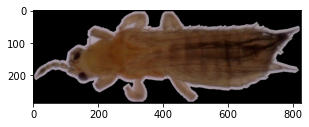

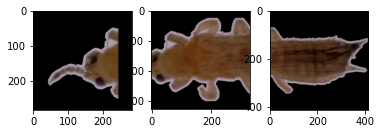

index: 0 | species: Plague Thrip


In [18]:
load_directional_classifier()
thrip_data = part_extraction(thrip_data_loader, path_to_save)
predict_thrip_species(thrip_data, "Augmented_ViT", path_for_models)